In [ ]:
#Keyword is dimensionality-reduction. 
#Important feature of topic_vectors: terms unranked per topic, topics unranked per document. 

#Future studies: increase number of terms, so that the term_topic vectors can be meaningfully 'ranked,' for k-medioids or consensus matrix buildling. 

In [82]:
%matplotlib inline 

In [1609]:
import bs4
from bs4 import BeautifulSoup as bsoup
import requests as rq
import re
import pandas
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem.snowball import SnowballStemmer
import datetime
from dateutil.parser import parse
import numpy as np
from numpy import exp
import tqdm #to show % progress when running
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import cosine
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import gensim 
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
import networkx as nx
from itertools import combinations
from collections import defaultdict
import pyLDAvis.gensim

In [2]:
%%time

blog_page_url_list = []
entry_author = []
time_posted = []
entry_text = [] 
linked_domains = [] #embedded hyperlinks
number_of_comments = []
first_comment_time = []

for page in range(12, 112): #Starting from page 12, the comments have been closed. 
    blog_page_url_list.append(f"https://marginalrevolution.com/page/{page}")

#post contents are on the blog pages, but comments are redirected. 

def find_linked_domains(links):
    domain_list = []
    if links != []:
        for link in links:
            search = re.search('^(?:https?:\/\/)?(?:[^@\/\n]+@)?(?:www\w*?\.)?([^:\/\n]+)', link)
            if search:
                domain_list.append(search.group(1))
    return domain_list

for url_ in blog_page_url_list:
    page_req = rq.get(url_, headers={'User-Agent': 'Mozilla/5.0'}) 
    
    if page_req.status_code == 200:  
        page_soup = bsoup(page_req.text) 
        
        for entry in page_soup.find_all('article', class_ = re.compile('post type-post')):

            if entry.header.div.span.string == 'Tyler Cowen':
                entry_author.append(1)
            elif entry.header.div.span.string == 'Alex Tabarrok':
                entry_author.append(0)
                
            time_posted.append(entry.header.div.time['datetime'])     

            entry_text_temp = ''
            embedded_links_temp = []
            for p in entry.find_all('p'):
                for c in p.contents: 
                        if c.name == 'a': 
                            embedded_links_temp.append(c['href'])
                        elif c.name == 'span':
                            if c.find('iframe') != None: #catch embedded webpages
                                embedded_links_temp.append(c.find('iframe')['src'])
                        elif c.name == 'img': #discard local images
                            try: 
                                if "wp-image" in c['class']:
                                    pass
                                else: 
                                    embedded_links_temp.append(c['src'])
                            except:
                                pass                           
                        else:            
                            entry_text_temp += str(c).replace(u'\xa0', u' ')
                       
            entry_text.append(entry_text_temp)   
            
            
            linked_domains.append(find_linked_domains(embedded_links_temp))
            
            number_of_comments_string = entry.footer.find('span', class_ ='meta-text').string
            number_of_comments.append(re.findall('^\d+', number_of_comments_string)[0])
            
            comments_link = entry.find('section', class_ = "post-actions").a['href']
            comments_req = rq.get(comments_link, headers={'User-Agent': 'Mozilla/5.0'})
            first_comment_soup = bsoup(comments_req.text).find('article', class_ = re.compile('blog-comment'))

            first_comment_time.append(first_comment_soup.time['datetime'])
        

CPU times: user 2min, sys: 3.15 s, total: 2min 4s
Wall time: 11min 30s


In [14]:
df = pandas.DataFrame([entry_author, time_posted, entry_text, linked_domains, number_of_comments, first_comment_time]).transpose()
df.columns = ['Entry Author', 'Time Posted', 'Entry Text', 'Linked Domains', 'Number of Comments', 'First Comment Time']

In [15]:
df

,Entry Author,Time Posted,Entry Text,Linked Domains,Number of Comments,First Comment Time
0,1,2020-05-28 01:29:22,The various subtleties of the title “Stubborn ...,[amazon.com],14,2020-05-28 02:57:28
1,1,2020-05-28 00:58:50,That is the new book by Stephanie Kelton and t...,[amazon.com],84,2020-05-28 01:09:33
2,1,2020-05-27 13:43:39,"Or a partial such allocation, at least. Here ...","[bloomberg.com, twitter.com]",68,2020-05-27 13:47:37
3,1,2020-05-27 11:49:08,"1. .2. .3. “”4. .5. ?6. , often highest for th...","[xavier.edu, voxeu.org, johnhcochrane.blogspot...",90,2020-05-27 11:54:03
4,1,2020-05-27 02:22:13,The National Science Foundation (NSF) would ge...,[sciencemag.org],121,2020-05-27 02:56:24
...,...,...,...,...,...,...
1495,1,2019-07-27 00:58:57,1. Organizations are <strong>SINGULAR</strong>...,"[itv.com, nationalaffairs.com]",103,2019-07-27 01:35:16
1496,1,2019-07-26 16:11:25,"By George Packer, I thought this book would be...","[google.com, amazon.com]",59,2019-07-26 16:26:38
1497,1,2019-07-26 11:52:06,"1. ! Wednesday, 2 p.m. (EST), register by Tue...","[pioneer.app, google.com, vulture.com, bbc.com...",54,2019-07-26 12:00:59
1498,1,2019-07-26 02:58:47,"That is the theme of , think of it as a new wa...","[bloomberg.com, static1.squarespace.com, londo...",88,2019-07-26 03:10:34


In [16]:
#Entry Text Cleaning:
#Remove all remaining tags from Entry Text
df['Entry Text'] = df['Entry Text'].str.replace(r'\<.*?\>', ' ')


In [17]:
#To lower case
df['Entry Text'] = df['Entry Text'].str.lower()


In [18]:
#Expand Contractions - note: quotation marks used in text are slanted, not straight. 
replacement_patterns = [
    (r'won\’t', 'will not'), 
    (r'can\’t', 'cannot'), 
    (r'i\’m', 'i am'),
    (r'ain\’t', 'is not'),
    (r'(\w+)\’ll', '\g<1> will'),
    (r'(\w+)n\’t', '\g<1> not'),
    (r'(\w+)\’ve', '\g<1> have'),
    (r'let\’s', 'let us'),
    (r'(\w+)\’s', '\g<1> is'),
    (r'(\w+)\’re', '\g<1> are'),
    (r'(\w+)\’d', '\g<1> would')]
    
def expand_contractions(s):
    for (pattern, repl) in replacement_patterns:
        s = re.sub(pattern, repl, s)
    return s

df['Entry Text'] = df['Entry Text'].apply(expand_contractions)


In [19]:
#Remove punctuations
df['Entry Text'] = df['Entry Text'].str.replace('[^\w\s]',' ')

In [ ]:
#It is better do some preprocessing and remove punctuations before saving to csv - pandas-to-csv does not handle quotations marks and apostrophes well. 

In [21]:
df.to_csv('raw_data.csv') #save as a checkpoint

In [99]:
df_1 = pandas.read_csv('raw_data.csv', index_col = 0)

In [100]:
df_1['Entry Text Length'] = [len(str(x).split()) for x in df_1['Entry Text']]

In [16]:
#Clean Linked Domains; get most frequently referenced domain names; create dummies. 


In [102]:
k = df_1['Linked Domains'].copy()
k = k.str.replace(r'\[', '')
k = k.str.replace(r'\]', '')
k = k.str.replace(r"\'", '')
#p = re.compile('\'\w+\-wpengine.*\'')
k = k.str.replace(p, '')

In [103]:
combined_links_string = ''
for x in k:
    for t in x.split(','):
        combined_links_string += t.strip() + '.'

In [104]:
combined_links_split = combined_links_string.split('.')

In [105]:
FreqDist(combined_links_split).most_common(30)

[('com', 4157),
 ('org', 911),
 ('twitter', 526),
 ('amazon', 328),
 ('marginalrevolution', 310),
 ('nytimes', 269),
 ('edu', 239),
 ('bloomberg', 142),
 ('washingtonpost', 142),
 ('nber', 132),
 ('google', 103),
 ('youtube', 99),
 ('en', 92),
 ('papers', 90),
 ('medium', 90),
 ('ssrn', 89),
 ('wikipedia', 85),
 ('wsj', 82),
 ('co', 69),
 ('theguardian', 65),
 ('uk', 64),
 ('bbc', 63),
 ('gov', 63),
 ('mercatus', 62),
 ('', 60),
 ('blogspot', 55),
 ('ft', 50),
 ('secure-web', 47),
 ('cisco', 47),
 ('2378nh2nfow32gm3mb25krmuyy-wpengine', 46)]

In [ ]:
#The top 15 most referenced (non-Google) domain names are:
#  ('twitter', 526),
#  ('amazon', 328),
#  ('marginalrevolution', 310),
#  ('nytimes', 269),
#  ('bloomberg', 142),
#  ('washingtonpost', 142),
#  ('nber', 132),
#  ('youtube', 99),
#  ('medium', 90),
#  ('ssrn', 89),
#  ('wikipedia', 85),
#  ('wsj', 82),
#  ('theguardian', 65),
#  ('bbc', 63),
#  ('mercatus', 62) - not the grocery delivery service, but mercatus.org, a thinktank at GWU. 

In [106]:
df_1['Twitter'] = [1 if 'twitter' in x else 0 for x in df_1['Linked Domains']]
df_1['Amazon'] = [1 if 'amazon' in x else 0 for x in df_1['Linked Domains']]
df_1['Self Reference'] = [1 if 'marginal' in x else 0 for x in df_1['Linked Domains']]
df_1['NY Times'] = [1 if 'nytimes' in x else 0 for x in df_1['Linked Domains']]
df_1['Bloomberg'] = [1 if 'bloomberg' in x else 0 for x in df_1['Linked Domains']]
df_1['WaPo'] = [1 if 'washingtonpost' in x else 0 for x in df_1['Linked Domains']]
df_1['NBER'] = [1 if 'nber' in x else 0 for x in df_1['Linked Domains']]
df_1['YouTube'] = [1 if 'youtube' in x else 0 for x in df_1['Linked Domains']]
df_1['Medium'] = [1 if 'medium' in x else 0 for x in df_1['Linked Domains']]
df_1['SSRN'] = [1 if 'ssrn' in x else 0 for x in df_1['Linked Domains']]
df_1['Wikipedia'] = [1 if 'wikipedia' in x else 0 for x in df_1['Linked Domains']]
df_1['WSJ'] = [1 if 'wsj' in x else 0 for x in df_1['Linked Domains']]
df_1['The Guardian'] = [1 if 'theguardian' in x else 0 for x in df_1['Linked Domains']]
df_1['BBC'] = [1 if 'bbc' in x else 0 for x in df_1['Linked Domains']]
df_1['Mercatus Center'] = [1 if 'mercatus' in x else 0 for x in df_1['Linked Domains']]

In [ ]:
#Turn time into epoch time; calculate post time since midnight & elapsed time from post to first response. 

In [107]:

def dt2epoch(value):
    d = parse(value)
    epoch = (d - datetime.datetime(1970,1,1)).total_seconds()
    return epoch    

df_1['Time Posted in Epoch'] = df_1['Time Posted'].apply(dt2epoch)

In [108]:
def secSinceMidnight(datTimStr):
    tt = pandas.to_datetime(datTimStr).time()
    return tt.hour * 3600 + tt.minute * 60 + tt.second

In [109]:
df_1['Time Posted Since Midnight'] = df_1['Time Posted'].apply(secSinceMidnight)

In [110]:
df_1['First Comment Time in Epoch'] = df_1['First Comment Time'].apply(dt2epoch)

In [111]:
df_1['First Response Since Post'] =  df_1['First Comment Time in Epoch'] - df_1['Time Posted in Epoch']

In [113]:
df_1.to_csv('transformed_data.csv')

In [ ]:
#Next, we'll build and tune the LDA model to generate topic-document vectors. 

In [6]:
df_2 = pandas.read_csv('transformed_data.csv', index_col = 0)

In [ ]:
# We have already accomplished 1. lower casing; 2. removing all punctuations.
# Next, we will: 3. remove stopwords; 4. stem; 5. remove most and least frequently used words (10%)

In [7]:
stop_words = stopwords.words('english')
stop_words.extend(["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", " p m ","pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"])


In [10]:
p = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
df_2['Entry Text'] = df_2['Entry Text'].str.replace(p, '')

In [11]:
#Check if we got any NaN values in df_2: 
rows_with_nan = []
for index, row in df_2.iterrows():
    is_nan_series = row.isnull()
    if is_nan_series.any():
        rows_with_nan.append(index)

In [12]:
rows_with_nan

[309, 934]

In [13]:
#drop these two rows: 
df_2 = df_2.drop([309, 934], axis = 0).reset_index()

In [14]:
df_2.to_csv('LDA_ready_data.csv')

In [17]:
stemmer = SnowballStemmer("english")

#5. find high and low frequency words. 
all_entries = ' '.join(entry for entry in df_2['Entry Text'])
stemmed_word_list = [stemmer.stem(word) for word in all_entries.split()]
word_frequency_distribution = FreqDist(stemmed_word_list)
k = len(word_frequency_distribution.most_common())//10
most_frequent_ten_percent_words = [x[0] for x in word_frequency_distribution.most_common(k)]
least_frequent_ten_percent_words = [x[0] for x in word_frequency_distribution.most_common()[-k: ]]

In [18]:
def tokenize_and_stem(text):
    tokens = text.split()
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = [token for token in tokens if token not in most_frequent_ten_percent_words]
    tokens = [token for token in tokens if token not in least_frequent_ten_percent_words]
    return tokens

text_data = []
for entry in df_2['Entry Text']:
    tokens = tokenize_and_stem(entry)
    text_data.append(tokens)

In [19]:
bigram = gensim.models.Phrases(text_data,min_count = 2, threshold = 0.1, scoring='npmi') 
trigram = gensim.models.Phrases(bigram[text_data])  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

trigram_text_data = [trigram_mod[bigram_mod[doc]] for doc in text_data]

/Users/gwengou/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [21]:
id2word = corpora.Dictionary(trigram_text_data)
# id2word.filter_extremes(no_below=2, no_above=0.35) 
# id2word.compactify() # remove gaps in id sequence after words that were removed
corpus = [id2word.doc2bow(doc) for doc in trigram_text_data]

In [22]:
200/len(id2word)

0.018053800324968405

In [87]:
%store corpus
%store id2word
%store trigram_text_data

Stored 'corpus' (list)
Stored 'id2word' (Dictionary)
Stored 'trigram_text_data' (list)


In [ ]:
%store -r corpus
%store -r id2word
%store -r trigram_text_data

In [23]:
#Hyperparameter tuning: find optimal number of topics, alpha, and beta by Coherence Score. 

In [328]:
def compute_coherence_values(corpus,dictionary, k, a, b):  
    lda_model = gensim.models.LdaModel(corpus=corpus,id2word=dictionary, num_topics=k,alpha=a,eta=b,
                                           passes = 5, #Use 5 for tuning purposes. Increasing passes will increase coherence score.
                                           random_state=100) #Use a fixed random_state here for tuning purposes.
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=trigram_text_data, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [333]:
#can take a long time to run

# Topics range
min_topics = 8
max_topics = 15 #The blog has 24 self-tagged "categories" but preliminary examinations showed ~10 optimal topics. 
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

#Typical values of alpha can be: an 1D array of length equal to the number of expected topics;’asymmetric’: Uses a fixed normalized asymmetric prior of 1.0 / topicno; ’auto’: Learns an asymmetric prior from the corpus.
#Typical value of beta is 0.1 or 200/number_of_words_in_vocabulary.
#Ideally, our composites should be made up of only a few topics and our words to belong to only some of the topics. With this in mind, alpha and beta are typically set below one.

# Alpha parameter
alpha = ['symmetric', 'asymmetric', 'auto']

# Beta parameter
beta = list(np.arange(0.01, 0.1, 0.02))
beta.append('auto')

model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# iterate through number of topics
for k in tqdm(topics_range, desc = 'k loop'):
    # iterate through alpha values
    for a in tqdm(alpha, desc = 'alpha loop'):
        # iterare through beta values
        for b in tqdm(beta, desc = 'beta loop'):
            # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k, a=a, b=b)
            # Save the model results
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)

/Users/gwengou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/gwengou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/gwengou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [334]:
pandas.DataFrame(model_results).to_csv('lda_tuning_results.csv', index = False)

In [335]:
best_params_index_row = pandas.DataFrame(model_results)['Coherence'].idxmax()
pandas.DataFrame(model_results).loc[best_params_index_row]

Topics              12
Alpha        symmetric
Beta              0.01
Coherence     0.715205
Name: 72, dtype: object

In [338]:
#Manually inspect the topics generated from this model, to check interpretability: 
check_topics_lda_model = gensim.models.LdaModel(corpus=corpus,id2word=id2word, num_topics=12,alpha='symmetric',eta=0.01,passes = 5, random_state=100) 
topics = check_topics_lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic) 

(0, '0.003*"senat" + 0.003*"volcker" + 0.002*"eastern" + 0.002*"comfort" + 0.002*"barro" + 0.002*"saliva" + 0.002*"slave" + 0.002*"hide" + 0.002*"sar_cov" + 0.002*"150"')
(1, '0.004*"bloomberg" + 0.003*"correspond" + 0.003*"levi" + 0.003*"muslim" + 0.003*"yorker" + 0.003*"vote" + 0.002*"elast" + 0.002*"australian" + 0.002*"imperi" + 0.002*"stagnat"')
(2, '0.004*"murray" + 0.004*"implicit" + 0.003*"chess" + 0.003*"tractor" + 0.003*"compon" + 0.003*"kidney" + 0.002*"proposit" + 0.002*"transplant" + 0.002*"son" + 0.002*"controversi"')
(3, '0.004*"escal" + 0.003*"villag" + 0.003*"wuhan" + 0.002*"tournament" + 0.002*"squirrel" + 0.002*"park" + 0.002*"chapter" + 0.002*"todd" + 0.002*"analyst" + 0.002*"zede"')
(4, '0.003*"bed" + 0.003*"nigel" + 0.003*"robbin" + 0.002*"gre" + 0.002*"sweden" + 0.002*"martin" + 0.002*"dinwiddi" + 0.002*"disrespect" + 0.002*"pool" + 0.002*"disast"')
(5, '0.003*"abhijit" + 0.003*"tree" + 0.002*"swedish" + 0.002*"algorithm" + 0.002*"februari" + 0.002*"height" + 0.0

In [ ]:
#Removing most- and least-frequently used 10% words when building the dictionary >> Using id2word.filter_extremes: the former generated coherence scores > 0.7 (very good!) while the latter hovered around 0.25; the former generated far more distinct and interprable topics. 

In [ ]:
#Having chosen the hyperparameters, we run the LDA model 5 times with different random_states. For each run, we convert the topic_document distribution vectors into a matrix, then into a dataframe. Then combine with df_2 (having reset the index as now we have two gaps in the row indices), and select columns to create a new dataframe for correlation matrix calculation.  

#The document_topics matrix can be quite sparse. 

In [252]:
%%time
result = pandas.DataFrame(columns = ['random_100 corr', 'random_100 terms', 'random_2000 corr', 'random_2000 terms','random_33333 corr', 'random_33333 terms','random_484759 corr', 'random_484759 terms','random_59995999 corr', 'random_59995999 terms'])

for random_state in [100,2000, 33333,484759,59995999]: 
    lda_model = gensim.models.LdaModel(corpus=corpus,id2word=id2word, num_topics=12,alpha='symmetric',eta=0.01,
                                               passes = 20, iterations = 400, #set passes and iterations high enough to ensure convergence. 
                                               random_state=random_state)
    matrix = np.zeros((1498,12))
    for k in range(1498): 
        topic_distribution = lda_model.get_document_topics(corpus[k])
        for t in topic_distribution:
            i, p = t
            try:
                if i in range(12):
                    matrix[k][i] = p
            except:
                matrix[k][i] = 0

    df_topics_doc = pandas.DataFrame(matrix,columns = ['Topic 0', 'Topic 1','Topic 2', 'Topic 3','Topic 4', 'Topic 5','Topic 6', 'Topic 7','Topic 8', 'Topic 9', 'Topic 10', 'Topic 11'])
    df_combined = pandas.concat([df_2, df_topics_doc], axis = 1, sort = False)
    df_corr_random = df_combined[[
     'Entry Author',
     #'Time Posted',
     #'Entry Text',
     #'Linked Domains',
     'Number of Comments',
     #'First Comment Time',
     'Entry Text Length',
     'Twitter',
     'Amazon',
     'Self Reference',
     'NY Times',
     'Bloomberg',
     'WaPo',
     'NBER',
     'YouTube',
     'Medium',
     'SSRN',
     'Wikipedia',
     'WSJ',
     'The Guardian',
     'BBC',
     'Mercatus Center',
     'Time Posted in Epoch',
     'Time Posted Since Midnight',
     'First Comment Time in Epoch',
     'First Response Since Post',
     'Topic 0',
     'Topic 1',
     'Topic 2',
     'Topic 3',
     'Topic 4',
     'Topic 5',
     'Topic 6',
     'Topic 7',
     'Topic 8',
     'Topic 9',
     'Topic 10',
     'Topic 11']].copy()

    corr = df_corr_random.corr(method='spearman')
    corr_with_time_posted_since_midnight = list(corr['Time Posted Since Midnight']['Topic 0':'Topic 11'])
    topic_terms = [x[1] for x in lda_model.print_topics()]
    temp = pandas.DataFrame([corr_with_time_posted_since_midnight, topic_terms]).transpose().sort_values(by=0)
    temp_corr = temp[0].tolist()
    temp_terms = temp[1].tolist()
    result['random_' + str(random_state) + ' corr'] = temp_corr
    result['random_' + str(random_state) + ' terms'] = temp_terms

CPU times: user 2min 39s, sys: 831 ms, total: 2min 40s
Wall time: 2min 41s


In [411]:
%store df_corr_random #keep the df_corr_random generated from random_state = 59995999 for future references. 

Stored 'df_corr_random' (DataFrame)


In [413]:
#The following code is used to find/visualize significant correlations bewteen the LDA-generated topic vectors and any external feature for each individual run: 

#mask = np.triu(np.ones_like(corr, dtype=np.bool))
#sns.heatmap(corr, cmap = sns.diverging_palette(180, 10, as_cmap=True), mask = mask)

def spearmanr_pval(x,y):
    return format(spearmanr(x,y)[1], '.4f')
corr_p = df_corr_random.corr(method=spearmanr_pval)
#corr_p.style.apply(lambda x: ["background-color:pink" if v <0.01 else "" for v in x], axis = 1)
#corr.style.apply(lambda x: ["background-color:pink" if abs(v) > 0.2 else "" for v in x], axis = 1)

test_corr = corr.mask(corr_p >= 0.01).copy()
test_corr.style.apply(lambda x: ["background-color:pink" if abs(v) >=0.2 else "" for v in x], axis = 1)

#===========
#After multiple runs with different random_states, it is clear that 'Entry Text Length' and 'Time Posted Since Midnight' are strongly correlated with the topic vectors. Since 'Entry Text Length' was generated from "Entry Text" and the correlation may well be a symptom of the LDA model (e.g. longer texts --> less concentrated topics), we focus on the rank correlation between the topic vectors and 'Time Posted Since Midnight.'(the later in the day a post is posted, the more "topic-intense" the post is?)

,Entry Author,Number of Comments,Entry Text Length,Twitter,Amazon,Self Reference,NY Times,Bloomberg,WaPo,NBER,YouTube,Medium,SSRN,Wikipedia,WSJ,The Guardian,BBC,Mercatus Center,Time Posted in Epoch,Time Posted Since Midnight,First Comment Time in Epoch,First Response Since Post,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11
Entry Author,nan,-0.0833661,-0.260888,0.0919307,nan,-0.239562,nan,0.0740918,nan,nan,nan,nan,nan,nan,nan,nan,0.0668608,nan,nan,nan,nan,nan,0.101957,0.118708,0.11631,0.0801673,0.085411,0.105168,0.0847228,0.0931935,0.0724097,0.110615,0.0830994,0.107796
Number of Comments,-0.0833661,nan,0.0906001,0.176011,-0.0991576,nan,0.156249,0.19085,0.152969,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.147359,nan,0.147299,-0.324402,nan,nan,nan,nan,nan,nan,nan,0.0778513,nan,nan,nan,nan
Entry Text Length,-0.260888,0.0906001,nan,-0.16934,0.141571,0.220538,-0.165753,0.0943267,-0.160667,nan,-0.0966631,nan,nan,0.0926748,nan,-0.10223,-0.168038,nan,0.0995135,-0.411256,0.0995209,nan,-0.567162,-0.520335,-0.603234,-0.574479,-0.529745,-0.580549,-0.60458,-0.553409,-0.560849,-0.573267,-0.590709,-0.552804
Twitter,0.0919307,0.176011,-0.16934,nan,-0.142276,nan,0.171668,nan,0.145166,nan,0.075187,nan,nan,nan,0.0907798,nan,0.131512,0.0754608,0.0912186,0.0884807,0.091215,-0.101173,0.14278,0.132078,0.161445,0.182566,0.169988,0.163253,0.192145,0.18808,0.15504,0.186191,0.159506,0.111266
Amazon,nan,-0.0991576,0.141571,-0.142276,nan,nan,nan,-0.091979,nan,nan,nan,0.0761224,-0.0740644,nan,nan,nan,nan,nan,-0.105142,-0.146163,-0.105112,0.119919,-0.0719084,nan,-0.0701094,-0.0760887,nan,-0.0745962,-0.0944682,nan,nan,-0.0949806,nan,nan
Self Reference,-0.239562,nan,0.220538,nan,nan,nan,nan,nan,-0.0776818,nan,nan,nan,nan,0.0973053,nan,nan,nan,nan,0.0935373,-0.0997124,0.0935373,nan,-0.0845982,-0.0967595,-0.108805,nan,-0.0851283,-0.0800436,-0.101078,-0.0843134,-0.0970046,-0.0787752,-0.0860088,nan
NY Times,nan,0.156249,-0.165753,0.171668,nan,nan,nan,nan,0.146344,nan,0.0927325,nan,nan,nan,nan,0.136779,0.179939,nan,nan,0.119606,nan,-0.0778811,0.177474,0.149018,0.153712,0.15204,0.130328,0.188513,0.160914,0.152426,0.139273,0.195554,0.127806,0.121782
Bloomberg,0.0740918,0.19085,0.0943267,nan,-0.091979,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.0957292,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
WaPo,nan,0.152969,-0.160667,0.145166,nan,-0.0776818,0.146344,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0877088,nan,0.114585,nan,-0.0890164,0.145254,0.125527,0.126506,0.112121,0.146637,0.16171,0.149742,0.138192,0.120853,0.136958,0.130309,0.121029
NBER,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [257]:
%store result

Stored 'result' (DataFrame)


In [389]:
result

,random_100 corr,random_100 terms,random_2000 corr,random_2000 terms,random_33333 corr,random_33333 terms,random_484759 corr,random_484759 terms,random_59995999 corr,random_59995999 terms
0,0.217796,"0.003*""nigel"" + 0.003*""robbin"" + 0.002*""keyn"" ...",0.211200,"0.004*""cast"" + 0.003*""disrespect"" + 0.003*""win...",0.221835,"0.003*""chess"" + 0.002*""gre"" + 0.002*""communist...",0.210950,"0.003*""labour"" + 0.003*""senat"" + 0.002*""chess""...",0.206719,"0.003*""sar_cov"" + 0.003*""award"" + 0.003*""chief..."
1,0.222844,"0.003*""chess"" + 0.003*""sweden"" + 0.003*""tether...",0.223808,"0.003*""implicit"" + 0.003*""boomer"" + 0.003*""tet...",0.224800,"0.003*""invent"" + 0.002*""zede"" + 0.002*""transpl...",0.214950,"0.003*""nigel"" + 0.002*""pool"" + 0.002*""influenz...",0.224782,"0.003*""labour"" + 0.003*""sander"" + 0.003*""kn95""..."
2,0.225800,"0.003*""dinwiddi"" + 0.002*""zede"" + 0.002*""treas...",0.232468,"0.003*""nativ"" + 0.003*""chess"" + 0.002*""sweden""...",0.226283,"0.003*""hierarchi"" + 0.003*""tree"" + 0.003*""tour...",0.218299,"0.003*""murray"" + 0.002*""tractor"" + 0.002*""prop...",0.226559,"0.004*""nigel"" + 0.003*""tractor"" + 0.003*""algor..."
3,0.226160,"0.003*""bed"" + 0.003*""bound"" + 0.003*""partner"" ...",0.233348,"0.003*""martin"" + 0.002*""abhijit"" + 0.002*""poli...",0.227573,"0.003*""tractor"" + 0.003*""cooper"" + 0.003*""pari...",0.221341,"0.003*""phase"" + 0.002*""nsf"" + 0.002*""displac"" ...",0.231323,"0.004*""boomer"" + 0.003*""contain"" + 0.003*""cast..."
4,0.232822,"0.004*""implicit"" + 0.003*""1970"" + 0.003*""tract...",0.243968,"0.004*""nigel"" + 0.004*""escal"" + 0.003*""tomb"" +...",0.233028,"0.003*""frank"" + 0.003*""labour"" + 0.003*""karach...",0.238461,"0.003*""isa"" + 0.003*""slave"" + 0.003*""diverg"" +...",0.233718,"0.002*""nber"" + 0.002*""robbin"" + 0.002*""chapter..."
5,0.243902,"0.003*""levi"" + 0.003*""yorker"" + 0.003*""abhijit...",0.244197,"0.003*""tractor"" + 0.003*""bill"" + 0.002*""easter...",0.236811,"0.003*""murray"" + 0.003*""nigel"" + 0.003*""tether...",0.243774,"0.002*""australian"" + 0.002*""barro"" + 0.002*""al...",0.239855,"0.004*""migrat"" + 0.003*""isa"" + 0.003*""sweden"" ..."
6,0.245517,"0.003*""senat"" + 0.002*""advis"" + 0.002*""barro"" ...",0.245813,"0.004*""teacher"" + 0.004*""racial"" + 0.003*""slav...",0.237103,"0.005*""swedish"" + 0.003*""sweden"" + 0.003*""bail...",0.246858,"0.003*""tether_pair"" + 0.003*""algorithm"" + 0.00...",0.245573,"0.004*""elast"" + 0.003*""teacher"" + 0.003*""provi..."
7,0.248729,"0.003*""phase"" + 0.003*""tomb"" + 0.003*""analyst""...",0.252954,"0.004*""robbin"" + 0.003*""1000"" + 0.003*""kn95"" +...",0.238247,"0.003*""appl"" + 0.003*""cebu"" + 0.002*""migrat"" +...",0.247824,"0.004*""robbin"" + 0.003*""nativ"" + 0.003*""club"" ...",0.248318,"0.004*""conscienti"" + 0.004*""chess"" + 0.003*""na..."
8,0.250968,"0.004*""racial"" + 0.003*""compon"" + 0.003*""rap"" ...",0.260667,"0.003*""bloomberg"" + 0.003*""2011"" + 0.002*""nsf""...",0.249470,"0.004*""johnson"" + 0.003*""svalbard"" + 0.003*""kn...",0.252438,"0.004*""boomer"" + 0.003*""johnson"" + 0.003*""sval...",0.249980,"0.003*""invent"" + 0.003*""bail"" + 0.003*""svalbar..."
9,0.256984,"0.004*""murray"" + 0.003*""coloni"" + 0.003*""facil...",0.264014,"0.003*""gre"" + 0.003*""sex"" + 0.003*""inventor"" +...",0.264370,"0.002*""tomb"" + 0.002*""chapter"" + 0.002*""dinwid...",0.255971,"0.004*""migrat"" + 0.004*""implicit"" + 0.003*""con...",0.252126,"0.002*""slave"" + 0.002*""abhijit"" + 0.002*""nsf"" ..."


In [261]:
result_corr = result[['random_100 corr', 'random_2000 corr', 'random_33333 corr', 'random_484759 corr', 'random_59995999 corr']]

In [294]:
result_terms = result[['random_100 terms','random_2000 terms','random_33333 terms','random_484759 terms','random_59995999 terms']]

In [1673]:
result_terms['random_100 terms'][3]

'0.003*"bed" + 0.003*"bound" + 0.003*"partner" + 0.003*"norway" + 0.003*"svalbard" + 0.003*"nber" + 0.002*"martin" + 0.002*"credibl" + 0.002*"airbnb" + 0.002*"file"'

In [774]:
terms = []
for r in ['random_100 terms','random_2000 terms','random_33333 terms','random_484759 terms','random_59995999 terms']:
    for x in result_terms[r]:
        for s in x.split('+'):
            t = s.split('*')[1].strip().strip('"')
            terms.append(t)
            
    

In [761]:
len(terms) #5 random_states * 12 topics * 10 terms per topic

600

In [808]:
unique_terms = set(terms)
len(unique_terms) #285 unique terms out of 600

285

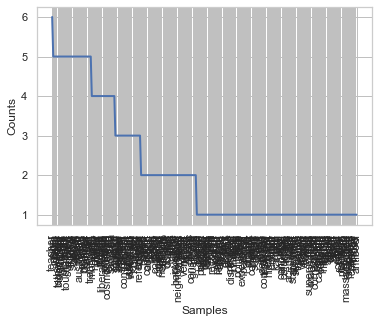

In [776]:
fdist = FreqDist(terms)
fdist.plot() #Some terms appeared in 2 different topics in a randon_state, therefore 6. 

In [764]:
f_count = {}
f_percent = {}
for i in range(1,7):
    f_count[i] = len(list(filter(lambda x: x[1]==i,fdist.items())))
    f_percent[i] = '{:.2%}'.format(len(list(filter(lambda x: x[1]==i,fdist.items())))/len(set(terms)))

In [765]:
f_count

{1: 150, 2: 52, 3: 24, 4: 22, 5: 36, 6: 1}

In [766]:
f_percent

{1: '52.63%', 2: '18.25%', 3: '8.42%', 4: '7.72%', 5: '12.63%', 6: '0.35%'}

In [767]:
f_all_terms_percent = {}
for i in range(1,7):
    f_all_terms_percent[i] = '{:.2%}'.format(len(list(filter(lambda x: x[1]==i,fdist.items())))/len(terms))

In [768]:
f_all_terms_percent

{1: '25.00%', 2: '8.67%', 3: '4.00%', 4: '3.67%', 5: '6.00%', 6: '0.17%'}

In [901]:
coverage = 0
for p in range(3,7): 
    coverage += float(f_all_terms_percent[p][:-1]) * p #terms that appeared in at least 3 random states cover nearly 60% of all terms shown. 
coverage

57.7

In [822]:
most_frequent_terms_collection = []
for term_count in list(filter(lambda x: x[1] >= 3,fdist.items())):
    most_frequent_terms_collection.append(term_count[0])

In [783]:
len(most_frequent_terms_collection)

83

In [ ]:
#Trying to visualize topic stability by reducing dimensionality of data. 

In [425]:
result.head(3)

,random_100 corr,random_100 terms,random_2000 corr,random_2000 terms,random_33333 corr,random_33333 terms,random_484759 corr,random_484759 terms,random_59995999 corr,random_59995999 terms
0,0.217796,"0.003*""nigel"" + 0.003*""robbin"" + 0.002*""keyn"" ...",0.211200,"0.004*""cast"" + 0.003*""disrespect"" + 0.003*""win...",0.221835,"0.003*""chess"" + 0.002*""gre"" + 0.002*""communist...",0.210950,"0.003*""labour"" + 0.003*""senat"" + 0.002*""chess""...",0.206719,"0.003*""sar_cov"" + 0.003*""award"" + 0.003*""chief..."
1,0.222844,"0.003*""chess"" + 0.003*""sweden"" + 0.003*""tether...",0.223808,"0.003*""implicit"" + 0.003*""boomer"" + 0.003*""tet...",0.224800,"0.003*""invent"" + 0.002*""zede"" + 0.002*""transpl...",0.214950,"0.003*""nigel"" + 0.002*""pool"" + 0.002*""influenz...",0.224782,"0.003*""labour"" + 0.003*""sander"" + 0.003*""kn95""..."
2,0.225800,"0.003*""dinwiddi"" + 0.002*""zede"" + 0.002*""treas...",0.232468,"0.003*""nativ"" + 0.003*""chess"" + 0.002*""sweden""...",0.226283,"0.003*""hierarchi"" + 0.003*""tree"" + 0.003*""tour...",0.218299,"0.003*""murray"" + 0.002*""tractor"" + 0.002*""prop...",0.226559,"0.004*""nigel"" + 0.003*""tractor"" + 0.003*""algor..."


In [1820]:
test = pandas.DataFrame()
for random_state in [100, 2000, 33333, 484759,59995999]:
    temp_corr = result['random_' + str(random_state) + ' corr']
    temp_terms = result['random_' + str(random_state) + ' terms']
    temp_term_list = pandas.DataFrame(columns = unique_terms)
    term_weighted_weight = []
    for i in range(len(temp_terms)):
        s_corr = temp_corr[i]
        s = temp_terms[i]
        for x in s.split('+'):
            w = float(x.split('*')[0].strip())
            t = x.split('*')[1].strip().strip('"')
            temp_term_list[t] = [w*s_corr]     #if there are duplicate terms in different topics, this takes the last weighted weight of that term. 
    test['random_' + str(random_state) + ' weighted weights'] = list(temp_term_list.transpose()[0])
    
test.index = unique_terms  
test = test.fillna(0)

In [1821]:
test

,random_100 weighted weights,random_2000 weighted weights,random_33333 weighted weights,random_484759 weighted weights,random_59995999 weighted weights
nigeria,0.000746,0.000506,0.000866,0.000488,0.000000
sweden,0.000669,0.000465,0.000711,0.000422,0.000720
gre,0.000446,0.000792,0.000444,0.000786,0.000467
pool,0.000698,0.000800,0.000466,0.000430,0.000544
scene,0.000436,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
elast,0.000698,0.000000,0.000000,0.000000,0.000982
asian,0.000000,0.000000,0.000000,0.000768,0.000000
wuhan,0.000491,0.000000,0.000000,0.000000,0.000000
labour,0.000519,0.000805,0.000699,0.000633,0.000674


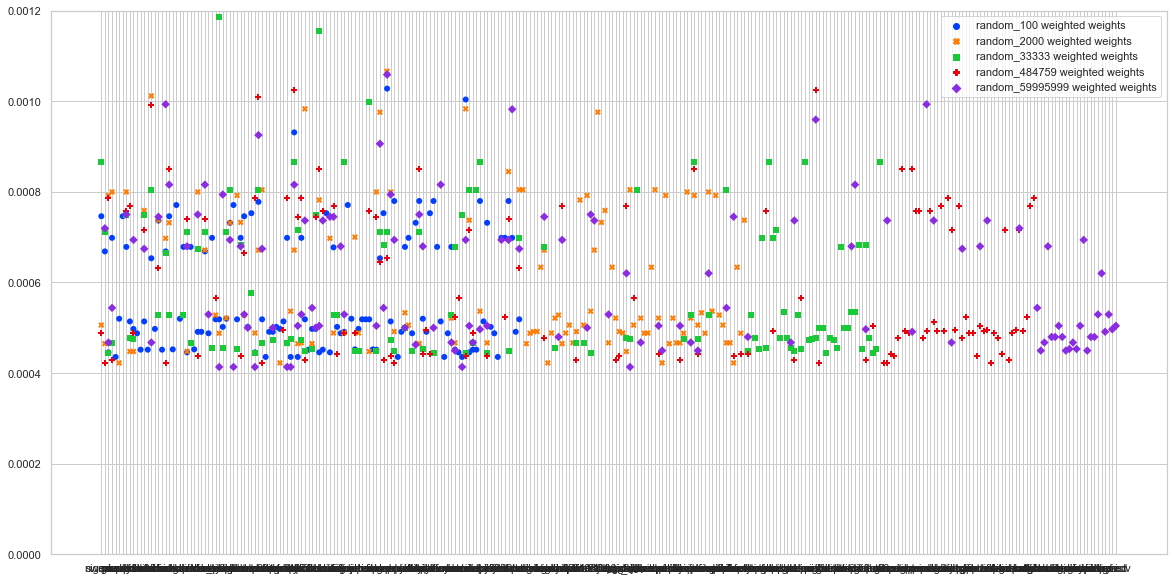

In [1350]:
#Get a sense of how the words disperse across random_states. 
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(20,10))
plt.ylim(0, 0.0012)
sns.scatterplot(data=test,
                palette="bright",
                sizes=(0, 0.02), linewidth=0)

In [1351]:
test_corr = test.corr(method='spearman')
def spearmanr_pval(x,y):
    return format(spearmanr(x,y)[1], '.4f')
test_corr_p = test.corr(method=spearmanr_pval)
#corr_p.style.apply(lambda x: ["background-color:pink" if v <0.01 else "" for v in x], axis = 1)
#corr.style.apply(lambda x: ["background-color:pink" if abs(v) > 0.2 else "" for v in x], axis = 1)

test_corr = test_corr.mask(test_corr_p >= 0.05).copy()
test_corr.style.apply(lambda x: ["background-color:pink" if abs(v) >=0.2 else "" for v in x], axis = 1)

,random_100 weighted weights,random_2000 weighted weights,random_33333 weighted weights,random_484759 weighted weights,random_59995999 weighted weights
random_100 weighted weights,nan,nan,nan,nan,0.312956
random_2000 weighted weights,nan,nan,nan,nan,0.249509
random_33333 weighted weights,nan,nan,nan,0.323987,nan
random_484759 weighted weights,nan,nan,0.323987,nan,nan
random_59995999 weighted weights,0.312956,0.249509,nan,nan,nan


In [1833]:
#In addition to/Instead of spearman, find cosine distance between the random_states:
random_states =  [100, 2000, 33333, 484759,59995999]
random_states_cosine_dict = defaultdict(float)
for r, q in combinations(random_states, 2):
    random_first, random_second = test['random_'+ str(r) + ' weighted weights'], test['random_'+ str(q) + ' weighted weights']
    random_states_cosine_dict['random_' + str(r) + '-' + 'random_'+ str(q)] = cosine(random_first, random_second)

In [1836]:
random_states_cosine_dict #random_100 and random_4XXX have the highest cosine similarity, followed by random_2000 and random_4XXXX, and then by random_100 adn random_20000. 

defaultdict(float,
            {'random_100-random_2000': 0.4907496233327895,
             'random_100-random_33333': 0.4220525395632615,
             'random_100-random_484759': 0.5148446764246215,
             'random_100-random_59995999': 0.4348426782158187,
             'random_2000-random_33333': 0.42971752301920585,
             'random_2000-random_484759': 0.5048178979922767,
             'random_2000-random_59995999': 0.4469744543460389,
             'random_33333-random_484759': 0.47653108079291895,
             'random_33333-random_59995999': 0.4387249288733166,
             'random_484759-random_59995999': 0.42689893579004534})

In [ ]:
#For comparison, use another measure of topic stabiltiy across random_states. 
#Get terms only, vectorize by mapping to a dictionary, use a custom jaccard similarity function to calculate pairwise correlation between topics, then plot networks graph with weighted edges.
#Note this approach does not consider the topic's relationship to an underlying topic distribution. It considers only the term-similarity between topics. 

In [ ]:
#Vectorize: Instead of all-terms mapping without order, map the terms by frequency. 

In [1051]:
term_list_by_frequency = [x[0] for x in fdist.most_common()]
i = range(0, len(term_list_by_frequency))
terms_dict = dict(zip(term_list_by_frequency, i))

#Map terms-topic mixtures to dictionary:
terms_vectors_by_frequency = pandas.DataFrame(columns = ['random_100 terms','random_2000 terms','random_33333 terms','random_484759 terms','random_59995999 terms'])
for random_state in [100, 2000, 33333, 484759,59995999]:
    random_state_topic_terms = []
    temp = result_terms['random_' + str(random_state) + ' terms'] 
    for s in temp:
        temp_topic_terms = []
        for x in s.split('+'):
            t = x.split('*')[1].strip().strip('"')
            temp_topic_terms.append(terms_dict[str(t)])
        random_state_topic_terms.append(temp_topic_terms)
    terms_vectors_by_frequency['random_' + str(random_state) + ' terms'] = random_state_topic_terms


In [1297]:
terms_vectors_by_frequency

,random_100 terms,random_2000 terms,random_33333 terms,random_484759 terms,random_59995999 terms
0,"[1, 2, 135, 37, 3, 136, 137, 138, 139, 59]","[35, 167, 168, 169, 170, 171, 70, 61, 104, 103]","[4, 11, 68, 9, 118, 79, 27, 21, 57, 202]","[32, 22, 4, 33, 228, 123, 126, 229, 5, 36]","[55, 78, 262, 37, 57, 59, 9, 100, 50, 20]"
1,"[4, 5, 6, 7, 8, 9, 10, 11, 38, 83]","[16, 31, 6, 54, 105, 51, 55, 26, 49, 8]","[24, 13, 36, 35, 0, 63, 42, 80, 81, 94]","[1, 19, 74, 0, 230, 48, 113, 80, 82, 72]","[32, 33, 29, 129, 56, 14, 263, 264, 265, 104]"
2,"[12, 13, 140, 14, 84, 39, 141, 142, 143, 60]","[38, 4, 5, 172, 34, 3, 20, 173, 71, 47]","[203, 54, 14, 67, 47, 204, 119, 205, 206, 53]","[28, 18, 30, 27, 109, 231, 232, 70, 24, 21]","[1, 18, 8, 53, 93, 132, 266, 124, 267, 268]"
3,"[85, 86, 144, 40, 15, 41, 42, 145, 146, 147]","[42, 21, 174, 72, 17, 14, 175, 106, 73, 176]","[18, 82, 207, 48, 120, 90, 112, 208, 65, 121]","[44, 75, 108, 53, 56, 233, 98, 81, 64, 234]","[31, 71, 35, 269, 27, 26, 36, 91, 43, 92]"
4,"[16, 17, 18, 19, 87, 20, 88, 89, 90, 91]","[1, 177, 25, 43, 178, 179, 180, 107, 108, 50]","[122, 32, 209, 19, 33, 20, 85, 74, 110, 39]","[127, 10, 128, 29, 235, 54, 236, 237, 129, 238]","[41, 2, 76, 11, 270, 271, 121, 114, 128, 39]"
5,"[92, 43, 21, 93, 148, 94, 95, 149, 61, 150]","[18, 181, 63, 9, 182, 12, 183, 184, 23, 185]","[28, 1, 6, 8, 210, 30, 211, 58, 17, 62]","[26, 23, 239, 240, 241, 45, 42, 39, 242, 243]","[58, 127, 5, 272, 273, 116, 274, 275, 81, 276]"
6,"[22, 96, 23, 62, 151, 152, 24, 153, 0, 154]","[0, 27, 10, 22, 186, 109, 74, 36, 187, 188]","[50, 5, 34, 69, 56, 26, 37, 107, 57, 212]","[6, 8, 35, 244, 122, 130, 245, 246, 247, 248]","[87, 0, 133, 105, 60, 80, 126, 131, 277, 134]"
7,"[44, 25, 155, 45, 46, 61, 47, 26, 63, 156]","[2, 189, 29, 110, 56, 190, 45, 191, 89, 111]","[213, 3, 58, 49, 214, 215, 55, 216, 217, 218]","[2, 38, 46, 3, 13, 249, 96, 131, 250, 101]","[130, 4, 38, 70, 22, 12, 54, 278, 82, 52]"
8,"[27, 97, 48, 157, 98, 158, 64, 99, 65, 159]","[7, 192, 75, 41, 193, 112, 113, 69, 76, 114]","[51, 15, 29, 46, 59, 40, 123, 219, 220, 221]","[31, 51, 15, 60, 251, 252, 253, 120, 118, 132]","[24, 34, 15, 79, 68, 46, 40, 99, 62, 115]"
9,"[28, 160, 161, 100, 29, 101, 162, 102, 30, 49]","[11, 67, 115, 194, 77, 195, 196, 116, 44, 66]","[25, 76, 12, 41, 22, 78, 86, 222, 223, 64]","[58, 16, 71, 12, 55, 254, 49, 255, 256, 133]","[10, 21, 75, 3, 13, 279, 280, 281, 72, 7]"


In [1518]:
def jaccard_similarity(x, y):
    number_intersect = len(x) + len(y) -len(set(x+y))              
    return number_intersect/len(set(x+y))

In [1519]:
#Get a sense of all possible j_scores in our model:
j_score_dict = dict(zip(list(range(11)), [i/(20-i) for i in range(11)]))

In [1520]:
j_score_dict

{0: 0.0,
 1: 0.05263157894736842,
 2: 0.1111111111111111,
 3: 0.17647058823529413,
 4: 0.25,
 5: 0.3333333333333333,
 6: 0.42857142857142855,
 7: 0.5384615384615384,
 8: 0.6666666666666666,
 9: 0.8181818181818182,
 10: 1.0}

In [1747]:
G = nx.Graph()
random_states =  [100, 2000, 33333, 484759,59995999]
for r, q in combinations(random_states, 2):
    random_first, random_second = terms_vectors_by_frequency['random_'+ str(r) + ' terms'], terms_vectors_by_frequency['random_'+ str(q) + ' terms']
    for i in range(12):
        for j in range(12):
            j_score = jaccard_similarity(random_first[i], random_second[j])
            if j_score >= j_score_dict[2]: #Interesting that no two topic_term vectors share 4 terms or more. 
                G.add_edge(i+r, j+q, weight = j_score)

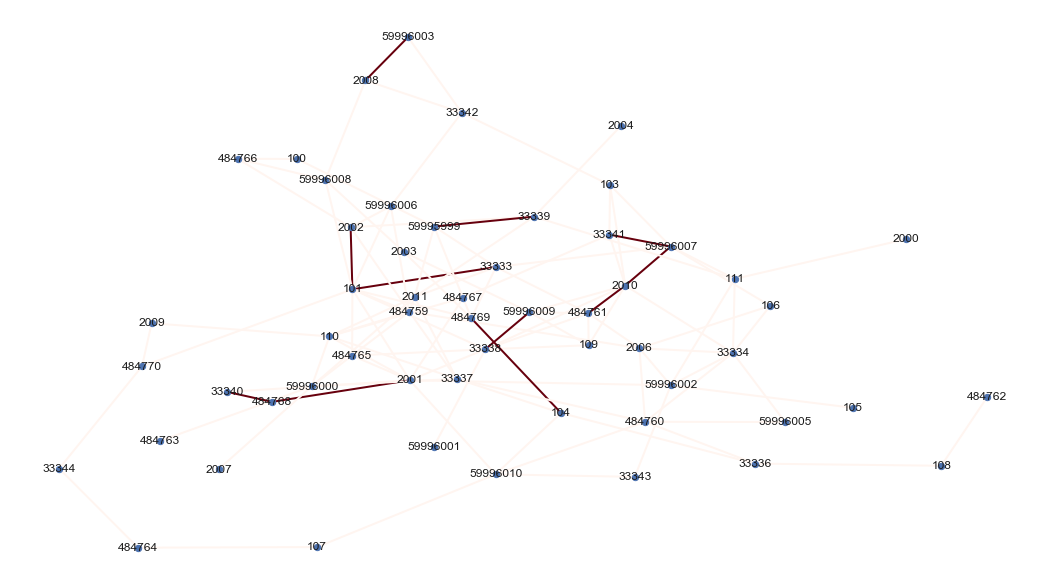

In [1372]:
pos = nx.spring_layout(G)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='k', font_family='sans-serif')
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
nx.draw(G, pos, node_size = 40, font_size = 8, node_color='b', edgelist=edges, edge_color=weights, width=2, edge_cmap=plt.cm.Reds) 
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('testpng.png', dpi=100)

In [1400]:
#It can be seen that 3-term related topics (clusters) are:
#(59996003, 2008), (59995999, 33338), (101,33333, 2002), (484769, 104), (33341, 59996007, 2010, 484761), (59996009, 33339) , (2001, 484768, 33340)
#random_state 3XXX has 5 topics that are 3-terms related (3 time with 5XXX, 3 times with 2XXX).  

In [1402]:
len(edges) #out of 12*12*10 possible edges, only 1/10 formed (with >=2 shared terms)

114

In [1803]:
temp_dict = nx.clustering(G, weight = weights) #showing clustering coefficient (fraction of possible triangles through that node)
{k: v for k, v in sorted(temp_dict.items(), key=lambda item: item[1], reverse = True)}

{109: 1.0,
 484765: 1.0,
 33340: 1.0,
 484768: 1.0,
 59996003: 1.0,
 59996005: 1.0,
 59996009: 0.6,
 103: 0.5,
 33341: 0.5,
 59996006: 0.5,
 33337: 0.4,
 484761: 0.4,
 59996000: 0.4,
 2011: 0.38095238095238093,
 106: 0.3333333333333333,
 110: 0.3333333333333333,
 484767: 0.3333333333333333,
 2008: 0.3333333333333333,
 2010: 0.32142857142857145,
 33338: 0.32142857142857145,
 484759: 0.32142857142857145,
 2002: 0.3,
 59995999: 0.3,
 33334: 0.23809523809523808,
 2006: 0.2,
 33333: 0.2,
 484769: 0.2,
 59996007: 0.2,
 33342: 0.16666666666666666,
 101: 0.15555555555555556,
 2001: 0.1388888888888889,
 59996002: 0.13333333333333333,
 484760: 0.13333333333333333,
 111: 0.1,
 33339: 0.1,
 2009: 0,
 2000: 0,
 104: 0,
 33336: 0,
 108: 0,
 100: 0,
 484766: 0,
 484770: 0,
 107: 0,
 484764: 0,
 484762: 0,
 59996008: 0,
 59996010: 0,
 105: 0,
 2004: 0,
 2003: 0,
 2007: 0,
 33344: 0,
 59996001: 0,
 33343: 0,
 484763: 0}

In [1811]:
#How to make use of the information above? 
#Add up the clustering coefficients of all topics in each random_state?  
test_dict = defaultdict(float)
for x in temp_dict.keys():
    test_dict[str(x)[0]] += temp_dict[x]

In [1812]:
test_dict

defaultdict(float,
            {'1': 2.4222222222222225,
             '2': 1.6746031746031744,
             '3': 2.9261904761904765,
             '4': 3.388095238095238,
             '5': 4.133333333333333})

In [ ]:
#Junk codes for reference only: 

In [ ]:
#Another way to visualize topic stabilty across random_states. Bubble size is number of 2- or 3-term edges formed, from 10 to 1.  

In [1410]:
test2 = defaultdict(int)
for e in edges:
    a, b = e
    test2[a] += 1
    test2[b] += 1

In [1454]:
temp_dict = {k: v for k, v in sorted(test2.items(), key=lambda item: item[1], reverse = True)}
df_test2 = pandas.DataFrame([temp_dict.keys(), temp_dict.values()]).transpose()

In [1455]:
temp_dict = {1:100, 2:2000, 3: 33333, 4:484759, 5: 59995999}
df_test2['random state as numerical'] = [int(str(x)[0]) for x in df_test2[0]]
df_test2['random state'] = [temp_dict[int(str(x)[0])] for x in df_test2[0]]
df_test2['topic number in that state'] = df_test2[0] - df_test2['random state']

In [1456]:
df_test2.head(4)

,0,1,random state as numerical,random state,topic number in that state
0,101,10,1,100,1
1,2001,9,2,2000,1
2,33338,8,3,33333,5
3,484759,8,4,484759,0


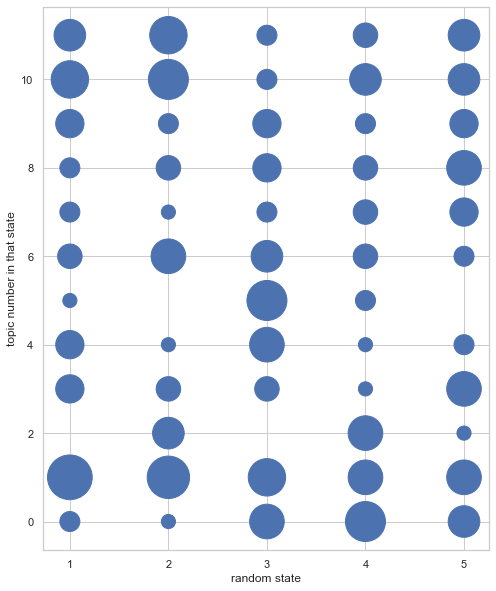

In [1477]:
plt.scatter(df_test2['random state as numerical'], df_test2['topic number in that state'], s=df_test2[1]*200)
plt.xlabel('random state')
plt.ylabel('topic number in that state')
fig2 = plt.gcf()
fig2.set_size_inches(8, 10)
fig2.savefig('testpng2.png', dpi=100)

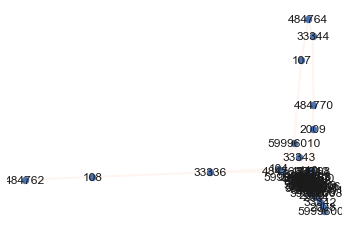

In [1754]:
#Map topics by eigenvalues of the distance matrix? 
pos = nx.spectral_layout(G)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='k', font_family='sans-serif')
nx.draw(G, pos, node_size = 40, node_color='b', edgelist=edges, edge_color=weights, width=2, edge_cmap=plt.cm.Reds) 

In [1780]:
#Starting collecting edges from 0-term topic pairs, all 1440: 
G_2 = nx.Graph()
random_states =  [100, 2000, 33333, 484759,59995999]
for r, q in combinations(random_states, 2):
    random_first, random_second = terms_vectors_by_frequency['random_'+ str(r) + ' terms'], terms_vectors_by_frequency['random_'+ str(q) + ' terms']
    for i in range(12):
        for j in range(12):
            j_score = jaccard_similarity(random_first[i], random_second[j])
            if j_score >= 0: #Interesting that no two topic_term vectors share 4 terms or more. 
                G_2.add_edge(i+r, j+q, weight = j_score)

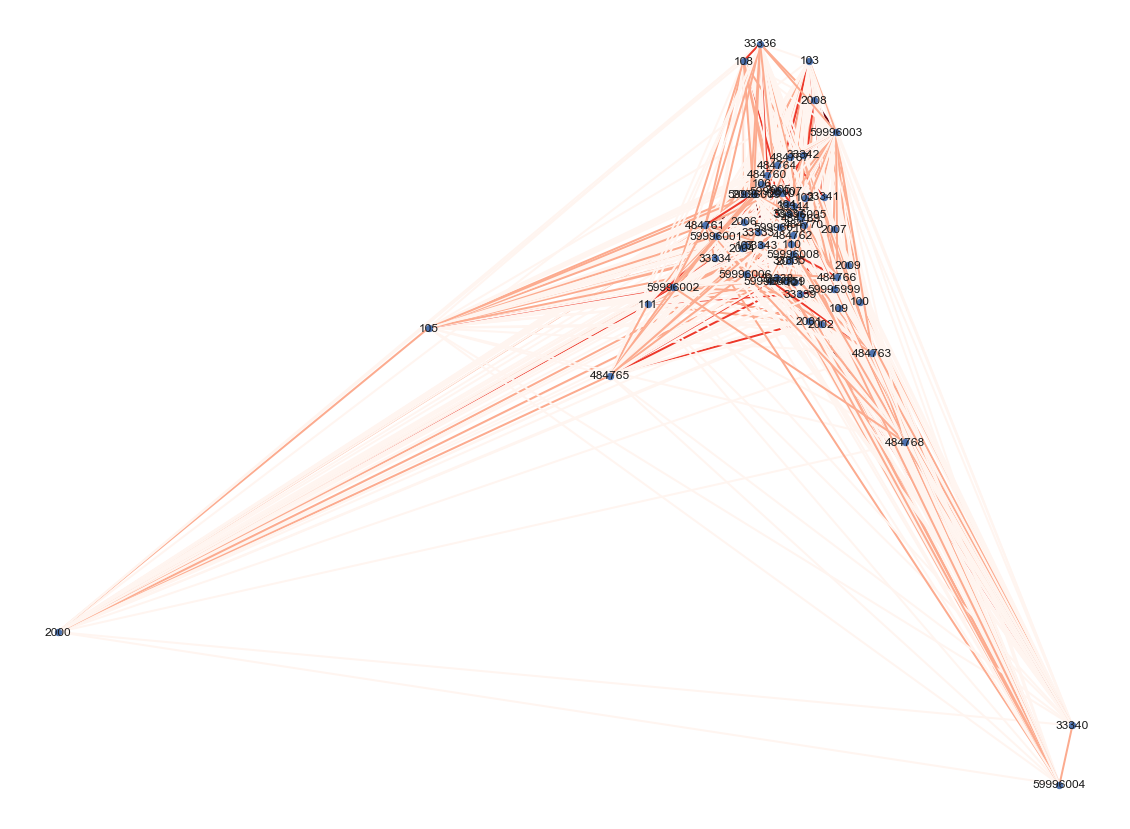

In [1781]:
pos = nx.spectral_layout(G_2, scale = 100)
edges,weights = zip(*nx.get_edge_attributes(G_2,'weight').items())
nx.draw_networkx_labels(G_2, pos, font_size=12, font_color='k', font_family='sans-serif')
nx.draw(G_2, pos, node_size = 40, node_color='b', edgelist=edges, edge_color=weights, width=2, edge_cmap=plt.cm.Reds) 
fig2 = plt.gcf()
fig2.set_size_inches(20, 15)

In [ ]:
#Inspect the terms of some related topics:

In [1360]:
result_terms['random_2000 terms'][2010-2000]

'0.004*"murray" + 0.003*"award" + 0.003*"invent" + 0.003*"svalbard" + 0.003*"pool" + 0.003*"proposit" + 0.003*"zede" + 0.003*"confer" + 0.002*"controversi" + 0.002*"norway"'

In [1363]:
result_terms['random_33333 terms'][33341-33333]

'0.004*"johnson" + 0.003*"svalbard" + 0.003*"kn95" + 0.003*"club" + 0.003*"modi" + 0.002*"norway" + 0.002*"moder" + 0.002*"eitc" + 0.002*"girl" + 0.002*"toler"'

In [1364]:
result_terms['random_59995999 terms'][59996007-59995999]

'0.003*"invent" + 0.003*"bail" + 0.003*"svalbard" + 0.003*"1980" + 0.002*"communist" + 0.002*"club" + 0.002*"norway" + 0.002*"iceland" + 0.002*"bengali" + 0.002*"inventor"'

In [1365]:
result_terms['random_484759 terms'][484761-484759]

'0.003*"murray" + 0.002*"tractor" + 0.002*"proposit" + 0.002*"racial" + 0.002*"quantit" + 0.002*"evolv" + 0.002*"genuin" + 0.002*"upfront" + 0.002*"invent" + 0.002*"abhijit"'

In [ ]:
#Use gensim's built-in diff function to compare topics between two runs of the LDA model: 

In [1674]:
m1 = gensim.models.LdaModel(corpus=corpus,id2word=id2word, num_topics=12,alpha='symmetric',eta=0.01,
                                           passes = 20, iterations = 400,
                                           random_state=100)

In [1675]:
m2 = gensim.models.LdaModel(corpus=corpus,id2word=id2word, num_topics=12,alpha='symmetric',eta=0.01,
                                           passes = 20, iterations = 400,
                                           random_state=2000)

In [1724]:
df_diff_jaccard = pandas.DataFrame(m1.diff(m2, distance='jaccard', num_words = 10)[0])

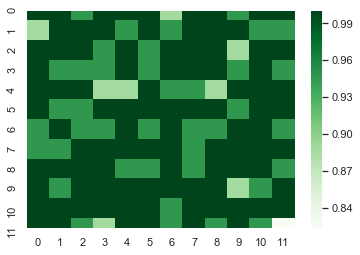

In [1725]:
sns.heatmap(df_diff_jaccard, cmap = "Greens")

In [1726]:
df_diff_kl = pandas.DataFrame(m1.diff(m2, distance='kullback_leibler', num_words = 10)[0])

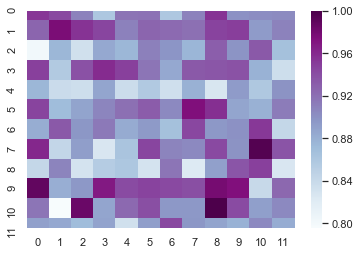

In [1727]:
sns.heatmap(df_diff_kl, cmap = 'BuPu')

In [1710]:
df_diff_kl_terms = pandas.DataFrame(m1.diff(m2, distance='kullback_leibler')[1])

In [1714]:
df_diff_kl_terms[2][0]

[['hilleman',
  'barro',
  'frozen',
  'decomposit',
  'dog',
  'zip_harbing',
  'comfort'],
 ['coupl',
  'weav',
  'technic',
  'keyboard',
  'attach',
  'royal',
  'voic_mail',
  'kolkata',
  'macro',
  'peac']]

In [ ]:
#Mantyla ran k-medioids clustering on topic_vectors. How does it make sense? Which distance metric did they use...... 

In [1582]:
#Try k-medoids clustering by using a Penalized Jaccard score for unranked lists: (compare: Greene's Top-Weighted Average Jaccard for ranked lists)
#Note that for each topic_term mixture, the weights of the top-10 terms are fairly close, so ranking within a topic does not help much much. 

In [1583]:
def average_jaccard(x, y):
    aj = 0
    for n in range(1, len(x)+1):
        temp_x = x[:n]
        temp_y = y[:n]
        aj += jaccard_similarity(temp_x, temp_y)/n
    return aj         

In [ ]:
#Try a custom penalized_jaccard: jaccard_similarity penalized by strata_distance between differing words. 

In [1594]:
f_count

{1: 150, 2: 52, 3: 24, 4: 22, 5: 36, 6: 1}

In [1597]:
rank_strata = [0]*1 + [1] *36 + [2]*22 + [3]*24 + [4]*52 + [5]*150

In [1599]:
len(rank_strata)

285

In [1602]:
term_rank_strata_dict = dict(zip(list(range(285)), rank_strata))

In [1668]:
def penalized_jaccard(x, y):
    j_score = jaccard_similarity(x, y)
    x_diff = [i for i in x if i not in y]
    y_diff = [j for j in y if j not in x]
    for i in x_diff:
        for j in y_diff:
            strata_distance = abs(term_rank_strata_dict[i]-term_rank_strata_dict[j])
            penalty = exp(-strata_distance)
            j_score = j_score * penalty        
    return  j_score

In [1669]:
from pyclustering.utils.metric import type_metric, distance_metric

penalized_jaccard_metric = distance_metric(type_metric.USER_DEFINED, func=penalized_jaccard)

In [1525]:
terms_vectors_by_frequency_list = []
for r in list(terms_vectors_by_frequency):
    temp = terms_vectors_by_frequency[r]
    for v in temp:
        terms_vectors_by_frequency_list.append(v)

In [1670]:
%%time
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.center_initializer import random_center_initializer

initial_index_medoids = random_center_initializer(terms_vectors_by_frequency_list, 12).initialize(return_index = True)

# Create instance of K-Medoids algorithm.
kmedoids_instance = kmedoids(data = terms_vectors_by_frequency_list, initial_index_medoids = initial_index_medoids, metric = penalized_jaccard_metric, itermax = 200, tolerance=0.001)
# Run cluster analysis and obtain results.
kmedoids_instance.process()


medoids = kmedoids_instance.get_medoids()
clusters = kmedoids_instance.get_clusters()



CPU times: user 1min 36s, sys: 275 ms, total: 1min 37s
Wall time: 1min 37s


In [1671]:
sorted(medoids)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [1672]:
clusters

[[2,
  12,
  13,
  14,
  16,
  18,
  19,
  20,
  21,
  23,
  24,
  27,
  29,
  30,
  31,
  32,
  35,
  36,
  37,
  38,
  39,
  40,
  42,
  47,
  48,
  50,
  51,
  53,
  56,
  58,
  59],
 [4, 25, 26, 33, 34, 41, 43, 44, 49, 52, 55, 57],
 [0, 15, 17, 22, 28, 45, 46, 54],
 [1],
 [3],
 [7],
 [5],
 [9],
 [6],
 [8],
 [10],
 [11]]

In [809]:
#One approach to mapping: Create a dictionary for unique_terms that appear in the topics:
i = range(0, len(unique_terms))
terms_dict = dict(zip(unique_terms, i))

#Map terms-topic mixtures to dictionary:
topic_terms_vectors = pandas.DataFrame(columns = ['random_100 terms','random_2000 terms','random_33333 terms','random_484759 terms','random_59995999 terms'])
for random_state in [100, 2000, 33333, 484759,59995999]:
    random_state_topic_terms = []
    temp = result_terms['random_' + str(random_state) + ' terms'] 
    for s in temp:
        temp_topic_terms = []
        for x in s.split('+'):
            t = x.split('*')[1].strip().strip('"')
            temp_topic_terms.append(terms_dict[str(t)])
        #temp_topic_terms.sort()
        random_state_topic_terms.append(temp_topic_terms) 
    topic_terms_vectors['random_' + str(random_state) + ' terms'] = random_state_topic_terms

In [ ]:
#A preliminary view of topic-similarity between two random_states can be shown using a heatmap. Not as efficient as using nx above. 

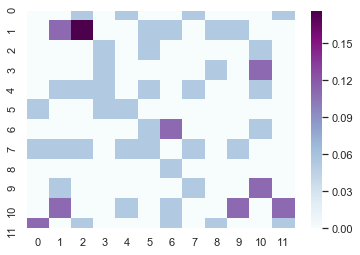

In [1204]:
sns.heatmap(pandas.DataFrame(jaccard_similarity_matrix), cmap = 'BuPu')

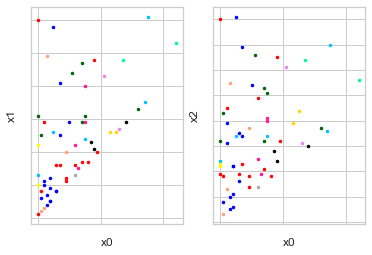

In [993]:
from pyclustering.cluster import cluster_visualizer_multidim
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, terms_vectors_by_frequency_list)
visualizer.show(pair_filter=[[0, 1], [0, 2]])
#Not very helpful. 

In [ ]:
#Results from a previous run of the LDA model: 

In [174]:
#random_state = 100
corr_with_time_posted_since_midnight = list(corr['Time Posted Since Midnight']['Topic 0':'Topic 11'])
topic_terms = [x[1] for x in lda_model.print_topics()]
random_100 = pandas.DataFrame(corr_with_time_posted_since_midnight, topic_terms).sort_values(by=0)

In [176]:
#random_state = 500
corr_with_time_posted_since_midnight = list(corr['Time Posted Since Midnight']['Topic 0':'Topic 11'])
topic_terms = [x[1] for x in lda_model.print_topics()]
random_500 = pandas.DataFrame(corr_with_time_posted_since_midnight, topic_terms).sort_values(by=0)

In [178]:
#random_state = 4000
corr_with_time_posted_since_midnight = list(corr['Time Posted Since Midnight']['Topic 0':'Topic 11'])
topic_terms = [x[1] for x in lda_model.print_topics()]
random_4000 = pandas.DataFrame(corr_with_time_posted_since_midnight, topic_terms).sort_values(by=0)

In [180]:
#random_state = 14938
corr_with_time_posted_since_midnight = list(corr['Time Posted Since Midnight']['Topic 0':'Topic 11'])
topic_terms = [x[1] for x in lda_model.print_topics()]
random_14938 = pandas.DataFrame(corr_with_time_posted_since_midnight, topic_terms).sort_values(by=0)

In [182]:
#random_state = 77777777
corr_with_time_posted_since_midnight = list(corr['Time Posted Since Midnight']['Topic 0':'Topic 11'])
topic_terms = [x[1] for x in lda_model.print_topics()]
random_77777777 = pandas.DataFrame(corr_with_time_posted_since_midnight, topic_terms).sort_values(by=0)

In [204]:
%store random_100
%store random_500 
%store random_4000
%store random_14938
%store random_77777777

Stored 'random_100' (DataFrame)
Stored 'random_500' (DataFrame)
Stored 'random_4000' (DataFrame)
Stored 'random_14938' (DataFrame)
Stored 'random_77777777' (DataFrame)


In [202]:
random_4000

,0
"0.003*""labour"" + 0.003*""nigel"" + 0.002*""communist"" + 0.002*""phase"" + 0.002*""sander"" + 0.002*""eastern"" + 0.002*""visa"" + 0.002*""nsf"" + 0.002*""lift"" + 0.002*""transplant""",0.198189
"0.003*""bail"" + 0.003*""site"" + 0.003*""actuari"" + 0.003*""nigeria"" + 0.002*""incid"" + 0.002*""show"" + 0.002*""neighborhood"" + 0.002*""muslim"" + 0.002*""submit"" + 0.002*""elast""",0.221340
"0.003*""cast"" + 0.003*""contain"" + 0.003*""300"" + 0.003*""modi"" + 0.003*""cebu"" + 0.003*""pari"" + 0.002*""asia"" + 0.002*""jamaica"" + 0.002*""toler"" + 0.002*""bengali""",0.231010
"0.003*""bed"" + 0.003*""jump"" + 0.002*""1970"" + 0.002*""cancel"" + 0.002*""crash"" + 0.002*""pdf"" + 0.002*""adapt"" + 0.002*""modest"" + 0.002*""kidney"" + 0.002*""200""",0.238852
"0.003*""overwhelm"" + 0.003*""sweden"" + 0.003*""gre"" + 0.003*""sex"" + 0.003*""1980"" + 0.002*""australian"" + 0.002*""cosmopolitan"" + 0.002*""abhijit"" + 0.002*""2009"" + 0.002*""tournament""",0.240938
"0.003*""tractor"" + 0.003*""squirrel"" + 0.003*""volcker"" + 0.003*""dinwiddi"" + 0.002*""neighborhood"" + 0.002*""acorn"" + 0.002*""thiel"" + 0.002*""liberaltarian"" + 0.002*""influenti"" + 0.002*""park""",0.241658
"0.004*""boomer"" + 0.003*""kn95"" + 0.003*""bloomberg"" + 0.002*""trip"" + 0.002*""girl"" + 0.002*""jazz"" + 0.002*""surveil"" + 0.002*""rap"" + 0.002*""ceqa"" + 0.002*""escal""",0.244936
"0.002*""constitut"" + 0.002*""paragraph"" + 0.002*""disrespect"" + 0.002*""levi"" + 0.002*""virginia"" + 0.002*""nobel"" + 0.002*""subway"" + 0.002*""politician"" + 0.002*""williamson"" + 0.002*""maxim""",0.246753
"0.003*""murray"" + 0.002*""implicit"" + 0.002*""tomb"" + 0.002*""proposit"" + 0.002*""chapter"" + 0.002*""correspond"" + 0.002*""refere"" + 0.002*""switch"" + 0.002*""sure"" + 0.002*""sar_cov""",0.254920
"0.003*""tree"" + 0.003*""teacher"" + 0.002*""pool"" + 0.002*""zede"" + 0.002*""framework"" + 0.002*""micro"" + 0.002*""keyn"" + 0.002*""lender"" + 0.002*""sba"" + 0.002*""avian""",0.257269


In [103]:
#Get a visual representation of the topics distribution 
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/gwengou/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [97]:
#PCA analysis? 
x = df_topics_doc.iloc[:,0:12].values
scaler = StandardScaler()
scaler.fit(x)
scaled_data = scaler.transform(x)

In [98]:
pca = PCA(n_components=4)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

In [99]:
print(pca.explained_variance_ratio_) #Very low explained variance, not meaningful. 

[0.09173584 0.0915836  0.09138969 0.09123415]
